In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd ..

/Users/dave/Library/CloudStorage/OneDrive-PolitecnicodiMilano/PhD/Repositories/partially-controllable-MDP


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import OrderedDict, defaultdict
import gymnasium as gym
import json
import matplotlib.ticker as ticker
from tqdm import trange
# from algo.utils import key_to_obs, build_state_index_map
# from pcmdp.utils import parameter_generator

In [206]:
# Use 'talk' if your plots are full-column width, or 'paper' for smaller ones.
sns.set_context("paper", font_scale=1.5) 

# Set a crisp white background with subtle gridlines (preferred)
# Use 'white' if you don't want any gridlines at all
sns.set_style('whitegrid', {
    'grid.linestyle': ':',  # Make grid lines dashed or dotted
    'grid.color': '.8',     # Light gray color for grid lines
    'font.family': 'serif'  # Often preferred for academic papers
}) 

# Use a specific high-contrast color palette
plot_colors = sns.color_palette('colorblind')

plt.rcParams['figure.figsize'] = (6, 4)  # Good default size for a single-column figure
plt.rcParams['lines.linewidth'] = 2.0    # Thicker lines for better visibility
plt.rcParams['axes.edgecolor'] = '0.15'  # Darker border for the plot area
plt.rcParams['axes.linewidth'] = 1.2     # Thicker axes lines
plt.rcParams['xtick.direction'] = 'in'   # Ticks inside the plot
plt.rcParams['ytick.direction'] = 'in'   # Ticks inside the plot
plt.rcParams['legend.frameon'] = True    # Always have a frame for the legend
plt.rcParams['legend.framealpha'] = 0.9  # Make the legend slightly transparent over the plot

alg_color = OrderedDict({
    #'random': plot_colors[5],
    #'longest_first': plot_colors[6],
    #'shortest_first': plot_colors[7],
    'ql': plot_colors[1],
    'exaq': plot_colors[0],
    'ucbvi': plot_colors[2],
    'exavi': plot_colors[3],
    'twap':  plot_colors[5],
    'allin': plot_colors[6],
    'ppo': plot_colors[4],
    'ppo_time': plot_colors[8],

})

alg_markers = OrderedDict({
    'random': '.',
    'longest_first': 'o',
    'shortest_first': 's',
    'ql': 's',
    'exaq': 's',
})

alg_labels = {
    'random': 'Random',
    'longest_first': 'LF',
    'shortest_first': 'SF',
    'ql': 'Q-Learning',
    'exaq': 'ExAQ',
    'ucbvi': 'UCBVI',
    'exavi': 'ExAVI',
    'twap': 'TWAP',
    'allin': 'ALL-IN',
    'ppo': 'PPO',
    'ppo_time': 'PPO with time'
}

In [139]:
plot_colors

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

In [93]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def plot_seed_curves(results_dict, 
                     algo, 
                     title="Evaluation Over Different Seeds", 
                     figsize=(8, 5), 
                     tick_step=100, 
                     max_idx=-1,
                     logscale=False,
                     no_cis=False,
                     legend_loc='best',
                     save_figure=False,
                     filename=''):
    """
    Plot mean evaluation return per seed for the selected algorithm,
    with 95% confidence intervals.
    
    results_dict: dict
        {algorithm: {seed: {episode: [returns, ...]}}}
    """
    plt.figure(figsize=figsize)
    seeds_dict = results_dict[algo]
    colors = sns.color_palette('colorblind', len(seeds_dict.keys()))
    
    for i, seed in enumerate(seeds_dict.keys()):
        seed_curve = seeds_dict[seed]
        episodes = np.array(sorted([int(k) for k in seed_curve.keys()]))
        episodes = episodes[:max_idx]
        
        per_episode_mean = np.array([np.mean(seed_curve[str(e)]) for e in episodes])
        plt.plot(episodes, per_episode_mean, label=seed, color=colors[i], linewidth=2)
        
        if not no_cis:
            sem = np.array([stats.sem(seed_curve[str(e)]) for e in episodes])
            ci95 = 1.96 * sem  # 95% confidence interval
            plt.fill_between(episodes, per_episode_mean - ci95, per_episode_mean + ci95, color=colors[i], alpha=0.2)

    plt.xlabel("Training Episode", fontsize=14)
    plt.ylabel("Evaluation Return by Learning Seed", fontsize=14)
    # plt.title(title, fontsize=16)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend(title="Seed", loc=legend_loc)
    
    step = max(1, tick_step)
    plt.xticks(np.arange(0, episodes.max()+1, step))
    if logscale:
        plt.xscale('log')
    
    plt.tight_layout()
    if save_figure:
        plt.savefig(filename, bbox_inches='tight') # Use vector format!
    plt.show()

    
def plot_learning_curves(results_dict, 
                         title="Evaluation Performance", 
                         figsize=(8, 5), 
                         tick_step=100,
                         max_idx=-1,
                         logscale=False,
                         save_figure=False,
                         filename=''):
    """
    Plot mean evaluation return per episode across seeds and algorithms,
    with 95% confidence intervals.
    
    results_dict: dict
        {algorithm: {seed: {episode: [returns, ...]}}}
    """
    plt.figure(figsize=figsize)
    
    for algo, seeds_dict in results_dict.items():
        # Collect per-seed mean reward per episode
        all_seeds_curves = []
        
        for seed, episodes_dict in seeds_dict.items():
            episodes = np.array(sorted([int(k) for k in episodes_dict.keys()]))
            if algo == 'ppox':
                episodes = episodes[:max_idx]          
            else:
                episodes = episodes[:max_idx]
            
            # mean over test evaluations for this seed
            per_episode_mean = np.array([np.mean(episodes_dict[str(e)]) for e in episodes])
            all_seeds_curves.append(per_episode_mean)
        
        all_seeds_curves = np.array(all_seeds_curves)  # shape (n_seeds, n_episodes)
        mean_curve = np.mean(all_seeds_curves, axis=0)
        sem = stats.sem(all_seeds_curves, axis=0)
        ci95 = 1.96 * sem  # 95% confidence interval
        
        if algo == 'ppox':
            plt.plot([ep for ep in episodes], mean_curve, label=alg_labels[algo], color=alg_color[algo], linewidth=2)
            plt.fill_between([ep for ep in episodes], mean_curve - ci95, mean_curve + ci95, color=alg_color[algo], alpha=0.2)
        else:
            plt.plot(episodes, mean_curve, label=alg_labels[algo], color=alg_color[algo], linewidth=2)
            plt.fill_between(episodes, mean_curve - ci95, mean_curve + ci95, color=alg_color[algo], alpha=0.2)
    
    plt.xlabel("Training Episode", fontsize=14)
    plt.ylabel("Evaluation Return (mean ± 95% CI)", fontsize=14)
    #plt.title(title, fontsize=14)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend(title="Algorithm")
    
    step = max(1, tick_step)
    plt.xticks(np.arange(0, episodes.max()+1, step))
    if logscale:
        plt.xscale('log')
    
    plt.tight_layout()
    if save_figure:
        plt.savefig(filename, bbox_inches='tight') # Use vector format!
    
    plt.show()

    
def summarize_final_performance(results_dict):
    summary = {}
    for algo, seeds_dict in results_dict.items():
        final_rewards = []
        for seed, episodes_dict in seeds_dict.items():
            last_ep = max(episodes_dict.keys())
            final_rewards.append(np.mean(episodes_dict[last_ep]))
        summary[algo] = {
            "mean_final": np.mean(final_rewards),
            "std_final": np.std(final_rewards),
            "ci95": 1.96 * np.std(final_rewards) / np.sqrt(len(final_rewards))
        }
    return summary


In [49]:
import numpy as np
import matplotlib.pyplot as plt

def iqm(data, lower_q=25, upper_q=75):
    """Interquartile mean: mean of values between given percentiles."""
    flat = np.sort(np.concatenate(data))
    l, u = np.percentile(flat, [lower_q, upper_q])
    return flat[(flat >= l) & (flat <= u)].mean()

def bootstrap_iqm_ci(data, n_boot=1000, ci=95):
    """Bootstrap confidence interval for IQM."""
    rng = np.random.default_rng()
    iqms = []
    n_seeds = len(data)
    for _ in range(n_boot):
        resample = [data[i] for i in rng.integers(0, n_seeds, n_seeds)]
        iqms.append(iqm(resample))
    lower = np.percentile(iqms, (100 - ci) / 2)
    upper = np.percentile(iqms, 100 - (100 - ci) / 2)
    return np.mean(iqms), (lower, upper)

def plot_iqm_curves(results_dict, n_boot=1000, ci=95, figsize=(8,5)):
    """
    results_dict: {algorithm: {seed: {episode: [returns,...], ...}, ...}}
    Plots IQM cumulative reward per episode with bootstrap CIs.
    """
    plt.figure(figsize=figsize)

    for algo, seeds_dict in results_dict.items():
        episodes = next(iter(seeds_dict.values())).keys()
        iqm_means, iqm_lows, iqm_highs = [], [], []

        for ep in episodes:
            # gather all returns across seeds at this episode
            data = [seeds_dict[s][ep] for s in seeds_dict]
            m, (l, u) = bootstrap_iqm_ci(data, n_boot=n_boot, ci=ci)
            iqm_means.append(m)
            iqm_lows.append(l)
            iqm_highs.append(u)

        plt.plot(episodes, iqm_means, label=alg_labels[algo], color=alg_color[algo])
        plt.fill_between(episodes, iqm_lows, iqm_highs, alpha=0.2)

    plt.xlabel("Training Episode")
    plt.ylabel("Cumulative Reward (IQM ± CI)")
    plt.title("Learning Curves with Interquartile Mean and Bootstrap CIs")
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.show()


In [6]:
def plot_taxi_V_spatial(V, mode="mean"):
    """
    Visualize V[h, s] as a 5x5 grid for selected horizons, aggregated across passenger/destination states.
    V: np.ndarray of shape (H, 500)
    mode: how to aggregate over horizon ('mean', 'final', 'start')
    """
    env_settings = parameter_generator(world_file="pcmdp/taxi/world.yaml")
    env = gym.make("pcmdp/taxi-v0", settings=env_settings)
    
    keys, multipliers = build_state_index_map(env)
    
    H, S = V.shape
    grid_shape = (5, 5)
    n_passenger_locs = 5
    n_destinations = 4
    n_positions = 25  # 5x5 grid
    matrix = np.zeros((5,5))

    # Choose horizon slice or aggregate
    if mode == "mean":
        V_h = np.mean(V, axis=0)
    elif mode == "final":
        V_h = V[-1]
    elif mode == "start":
        V_h = V[0]
    else:
        raise ValueError("mode must be 'mean', 'final', or 'start'")

    # Aggregate by taxi position (averaging over passenger & destination states)
    spatial_V = np.zeros(n_positions)
    counts = np.zeros(n_positions)
    matrix_counts = np.zeros((5,5))
    for s in range(S):
        state = key_to_obs(s, env, keys, multipliers)
        taxi_row = state['row']
        taxi_col = state['col']
        idx = taxi_row * 5 + taxi_col
        spatial_V[idx] += V_h[s]
        matrix[taxi_row, taxi_col] += V_h[s]
        counts[idx] += 1
        matrix_counts[taxi_row, taxi_col] +=  1
    spatial_V /= np.maximum(counts, 1)
    matrix /= matrix_counts
    
    # Plot as heatmap
    plt.figure(figsize=(5, 5))
    im = plt.imshow(matrix, cmap="viridis", origin="upper")
    plt.colorbar(im, label="Value")
    plt.title(f"Aggregated Value Function ({mode}) across Passenger/Destination states")
    plt.xticks(range(5))
    plt.yticks(range(5))
    plt.grid(visible=None, alpha=0.3)
    plt.gca().invert_yaxis()
    plt.show()

    
def plot_taxi_Nsa_spatial(N_sa, mode="sum"):
    """
    Visualize state-action visitation for Taxi-v3.
    N_sa: np.ndarray of shape (500, 6)
    mode: 'sum' (aggregate over horizon) or 'final' (last step)
    """
    env_settings = parameter_generator(world_file="pcmdp/taxi/world.yaml")
    env = gym.make("pcmdp/taxi-v0", settings=env_settings)
    
    keys, multipliers = build_state_index_map(env)
    
    S, A = N_sa.shape
    grid_shape = (5, 5)
    n_positions = 25

    N = N_sa
    matrix = np.zeros((5,5))

    # Aggregate across passenger/destination for each (row, col)
    spatial_N = np.zeros((n_positions, A))
    counts = np.zeros(n_positions)
    matrix_counts = np.zeros((5,5))
    for s in range(S):
        state = key_to_obs(s, env, keys, multipliers)
        taxi_row = state['row']
        taxi_col = state['col']
        idx = taxi_row * 5 + taxi_col
        spatial_V[idx] += V_h[s]
        matrix[taxi_row, taxi_col] += V_h[s]
        counts[idx] += 1
        matrix_counts[taxi_row, taxi_col] += 1
    spatial_N /= np.maximum(counts[:, None], 1)
    matrix /= matrix_counts

    # Plot per-action heatmaps
    fig, axes = plt.subplots(1, A, figsize=(4*A, 4))
    actions = ["South", "North", "East", "West", "Pickup", "Dropoff"]
    for a in range(A):
        ax = axes[a]
        im = ax.imshow(np.log1p(matrix[:, a]),
                       cmap="magma", origin="upper")
        ax.set_title(f"Action: {actions[a]}")
        ax.set_xticks(range(5))
        ax.set_yticks(range(5))
        ax.invert_yaxis()
        fig.colorbar(im, ax=ax, shrink=0.7)
    plt.suptitle("Taxi-v3 State-Action Visit Counts (log scale)")
    plt.grid(False, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Taxi Environment

In [102]:
env = 'taxi'
exp_name = 'taxiTraffic'

res = {}
res['ucbvi'] = {}
res['exavi'] = {}

for i in range(1, 11):
    with open(f'logs/results/{env}/{exp_name}/exavi/2025-12-14_12-44-15/{i}/learning_curve.json', 'rb') as f:
        res['exavi'][i] = json.load(f)

    with open(f'logs/results/{env}/{exp_name}/ucbvi/2025-12-14_12-41-45/{i}/learning_curve.json', 'rb') as f:
        res['ucbvi'][i] = json.load(f)

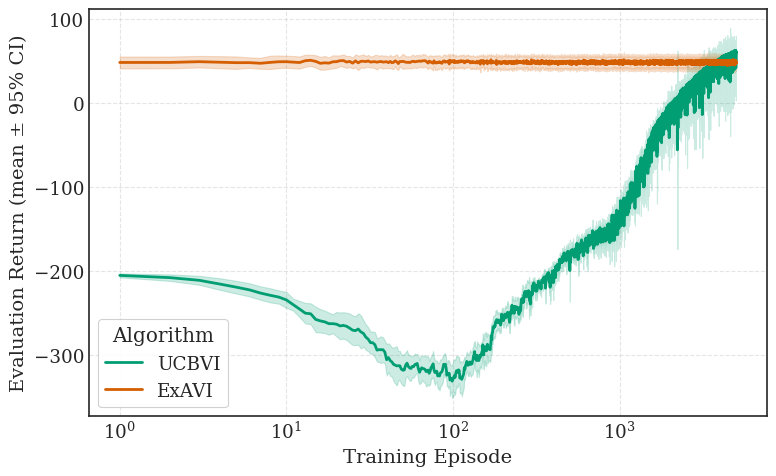

In [103]:
plot_learning_curves(res, tick_step=1000, logscale=True)

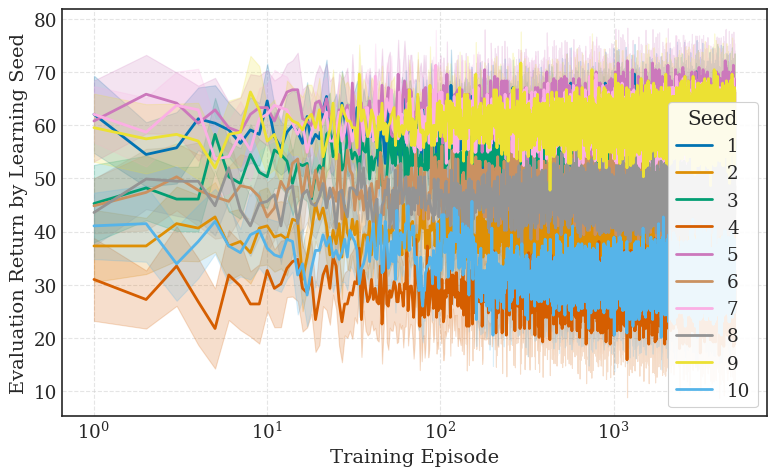

In [104]:
plot_seed_curves(res, 'exavi', logscale=True, no_cis=False, legend_loc='lower right')

In [105]:
env = 'taxi'
exp_name = 'taxiTraffic'

res = {}
res['ql'] = {}
res['exaq'] = {}

for i in range(1, 11):
    with open(f'logs/results/{env}/{exp_name}/exaq/2025-12-14_12-41-27/{i}/learning_curve.json', 'rb') as f:
        res['exaq'][i] = json.load(f)

    with open(f'logs/results/{env}/{exp_name}/ql/2025-12-14_12-43-12/{i}/learning_curve.json', 'rb') as f:
        res['ql'][i] = json.load(f)

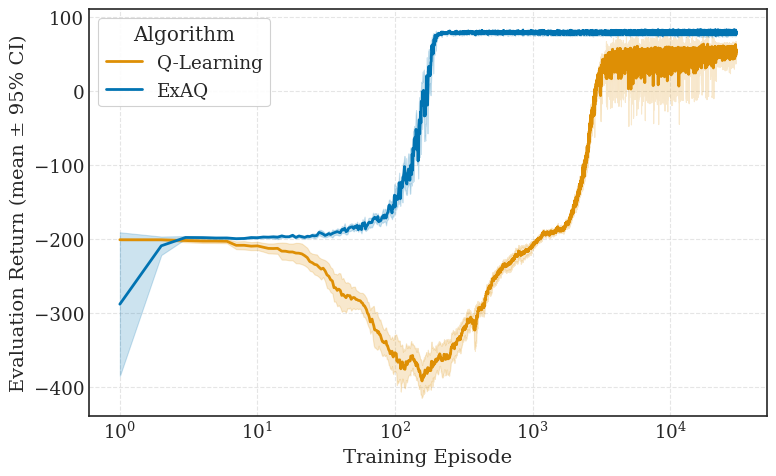

In [106]:
plot_learning_curves(res, tick_step=1000, logscale=True)

In [11]:
#plot_seed_curves(res, algo='exavi', tick_step=1000)

In [12]:
#import pickle

#with open("logs/results/taxi/10seeds/ucbvi/2025-11-08_17-16-01/6/world_models.pkl", "rb") as f:
#    data = pickle.load(f)
    
#V = data["V"]
#N_sa = data["N_sa"]

#plot_taxi_V_spatial(V)
#plot_taxi_Nsa_spatial(N_sa)

# Tiny Elevator Environment

In [98]:
env = 'elevator'
exp_name = 'seedFixedTinyElev'

res = {}
res['ucbvi'] = {}
res['exavi'] = {}

for i in trange(1, 11):
    with open(f'logs/results/{env}/{exp_name}/ucbvi/2025-11-20_14-24-14/{i}/learning_curve.json', 'rb') as f:
        res['ucbvi'][i] = json.load(f)

    with open(f'logs/results/{env}/{exp_name}/exavi/2025-11-20_14-41-27/{i}/learning_curve.json', 'rb') as f:
        res['exavi'][i] = json.load(f)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.93it/s]


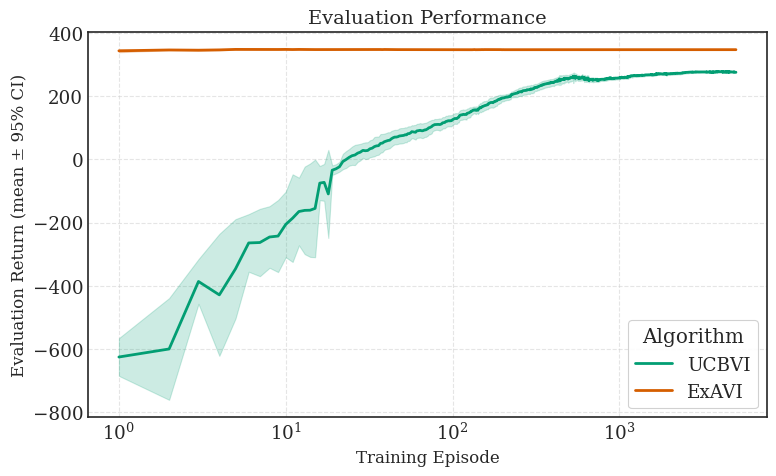

In [99]:
plot_learning_curves(res, tick_step=2000, logscale=True)

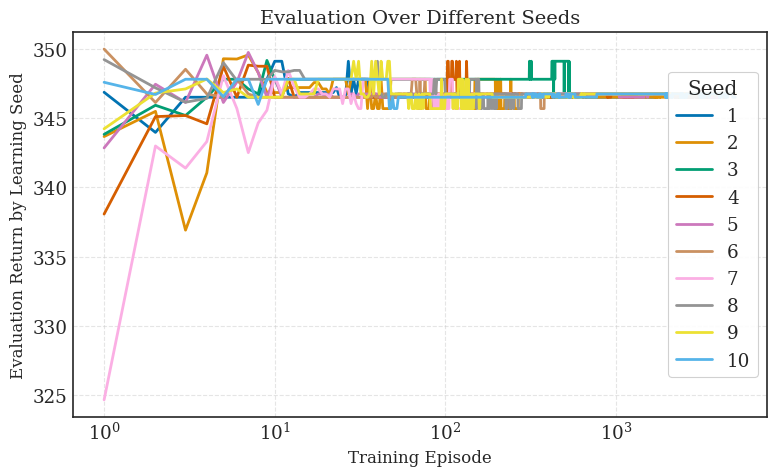

In [100]:
plot_seed_curves(res, 'exavi', logscale=True, no_cis=True, legend_loc='right')

In [93]:
env = 'elevator'
exp_name = 'seedFixedTinyElev'

res = {}
res['ql'] = {}
res['exaq'] = {}

for i in trange(1, 11):
    with open(f'logs/results/{env}/{exp_name}/exaq/2025-11-21_11-52-53/{i}/learning_curve.json', 'rb') as f:
        res['exaq'][i] = json.load(f)

    with open(f'logs/results/{env}/{exp_name}/ql/2025-11-20_12-46-20/{i}/learning_curve.json', 'rb') as f:
        res['ql'][i] = json.load(f)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.45it/s]


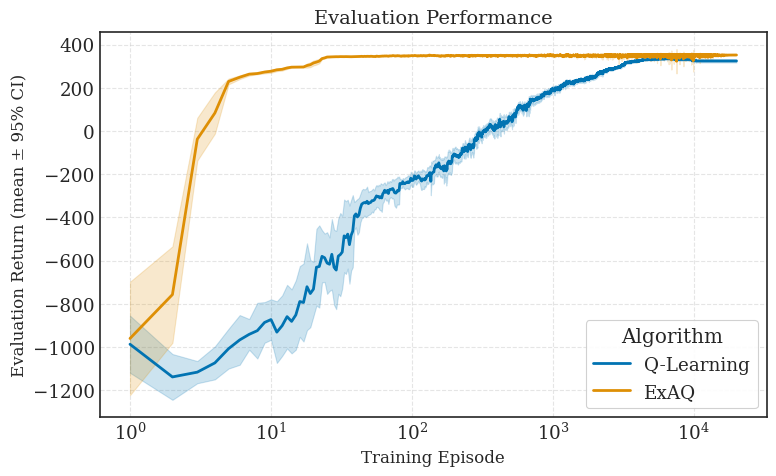

In [96]:
plot_learning_curves(res, tick_step=2000, max_idx=20000, logscale=True)

# Elevator Environment

In [89]:
env = 'elevator'
exp_name = 'seedFixedElev'

res = {}
res['ql'] = {}
res['exaq'] = {}

for i in trange(1, 11):
    with open(f'logs/results/{env}/{exp_name}/exaq/2025-11-21_16-24-44/{i}/learning_curve.json', 'rb') as f:
        res['exaq'][i] = json.load(f)

    with open(f'logs/results/{env}/{exp_name}/ql/2025-11-25_16-52-26/{i}/learning_curve.json', 'rb') as f:
        res['ql'][i] = json.load(f)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.57it/s]


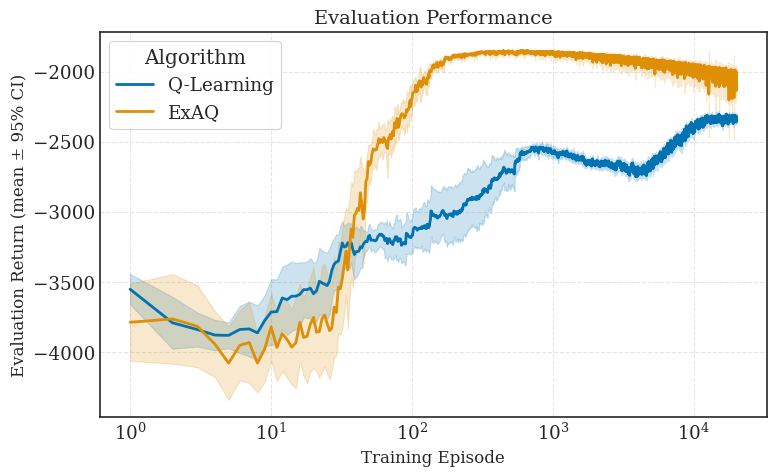

In [92]:
plot_learning_curves(res, tick_step=2000, logscale=True, max_idx=20000)

## Trading Env

In [183]:
env = 'trading'
exp_name = 'fixedS0'

res = {}
res['ql'] = {}
res['exaq'] = {}
res['ppo'] = {}

for i in trange(1, 11):
    with open(f'logs/results/{env}/{exp_name}/exaq/2025-11-26_20-28-41/{i}/learning_curve.json', 'rb') as f:
        res['exaq'][i] = json.load(f)

    with open(f'logs/results/{env}/{exp_name}/ql/2025-11-26_17-42-09/{i}/learning_curve.json', 'rb') as f:
        res['ql'][i] = json.load(f)
        
    with open(f'logs/results/{env}/{exp_name}noTime/ppo/2025-12-24_10-45-06/{i}/learning_curve.json', 'rb') as f:
        res['ppo'][i] = json.load(f)

100%|██████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.43s/it]


In [184]:
for i in trange(1, 11):
    for ep in range(2000, 20000):
        res['ppo'][i][str(ep)] = [res['ppo'][i]['1999']] * 50

100%|██████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.13it/s]


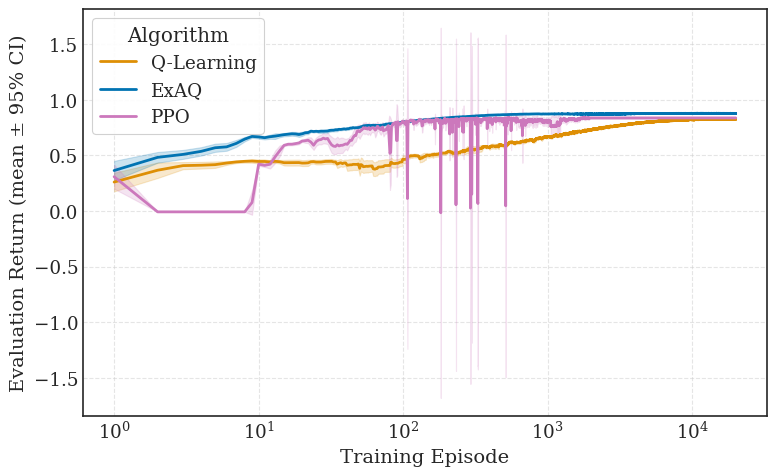

In [185]:
plot_learning_curves(res, tick_step=5000, max_idx=30000, logscale=True)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (19998,) + inhomogeneous part.

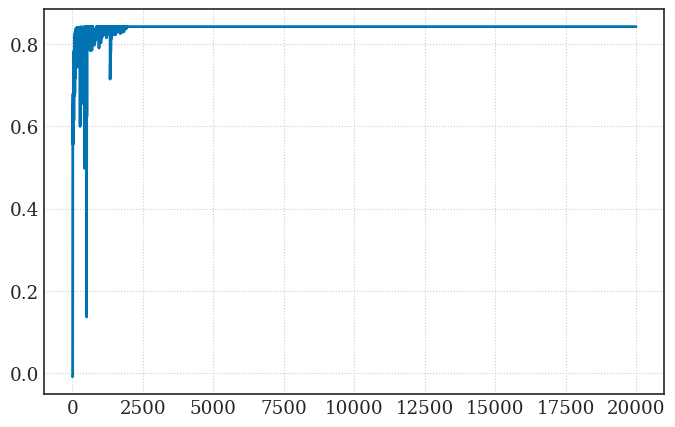

In [186]:
plot_seed_curves(results_dict=res, algo='ppo')

In [209]:
import pickle
import os
from tqdm import trange
from pcmdp.utils import parameter_generator
from algo.utils import *
import pcmdp

def load_q_table(path):
    """Load a saved Q-table from a pickle file."""
    if not os.path.exists(path):
        raise FileNotFoundError(f"Q-table file not found: {path}")
    with open(path, "rb") as f:
        Q = pickle.load(f)
    return np.array(Q)


def run_env(Q, env_id, params, seed, n_episodes, baseline=None, agent=None):

    ep_cum_rewards = []
    avg_amounts = []
    
    if agent is None:
        env = gym.make(f"pcmdp/{env_id}", **{'settings': params})
        keys, multipliers = build_state_index_map(env)
        
        # Select the function to get indices based on keys and multipliers
        get_indices = lambda obs, keys, multipliers: obs_to_key(obs, keys, multipliers)

        # Fixed seed for evaluation, to ensure reproducibility
        rng = np.random.default_rng(seed)

        for i in trange(n_episodes):
            seed = rng.integers(low=0, high=1e6, size=1)[0]
            obs, _ = env.reset(options={'seed': seed})
            obs_key = get_indices(obs, keys, multipliers)

            done = False
            rewards = np.zeros(200)
            amounts = np.zeros(200)
            t = 0

            while not done:
                if baseline == "twap":
                    action = obs['amount'] if t % 2 == 0 else obs['amount'] - 1
                elif baseline == "allin":
                    action = 0
                else:
                    action = np.argmax(Q[obs_key, :])           

                next_obs, reward, terminated, truncated, info = env.step(action)
                next_obs_key = get_indices(next_obs, keys, multipliers)

                amounts[t] = obs['amount']
                rewards[t] = reward
                t += 1

                done = terminated or truncated
                obs, obs_key = next_obs, next_obs_key

            ep_cum_rewards.append(np.cumsum(rewards))
            avg_amounts.append(amounts)

        # avg_cumulated_reward = np.mean(ep_cum_rewards) 
        # std_cumulated_reward = np.std(ep_cum_rewards)
        # ci95 = 1.96 * std_cumulated_reward / np.sqrt(len(ep_cum_rewards))
    
    else:
        from algo.ppo import NormalizeWrapper
        env = gym.make(f"pcmdp/{env_id}", **{'settings': params})
        env = NormalizeWrapper(env)
        
        # Fixed seed for evaluation, to ensure reproducibility
        rng = np.random.default_rng(seed)

        for i in trange(n_episodes):    
            seed = rng.integers(low=0, high=1e6, size=1)[0]
            obs, _ = env.reset(options={'seed': seed})

            done = False
            rewards = np.zeros(200)
            amounts = np.zeros(200)
            t = 0

            while not done:
                import torch
                # Assuming obs is already normalized by the wrapper above
                obs_tensor = torch.FloatTensor(obs).unsqueeze(0) # Add batch dim
                if next(agent.parameters()).is_cuda:
                    obs_tensor = obs_tensor.cuda()

                with torch.no_grad():
                    # Deterministic Eval: Use argmax of logits
                    logits = agent.actor(obs_tensor)
                    action = torch.argmax(logits, dim=1).item()            

                next_obs, reward, terminated, truncated, info = env.step(action)  
                
                amounts[t] = obs[0] * 100
                rewards[t] = reward
                t += 1

                done = terminated or truncated
                obs = next_obs
                
            ep_cum_rewards.append(np.cumsum(rewards))
            avg_amounts.append(amounts)
            
    return ep_cum_rewards, avg_amounts

In [204]:
def plot_strategies(results_dict, 
                    title="Execution Strategy", 
                    figsize=(8, 5), 
                    save_figure=False,
                    filename=''):
    """
    Plot strategies
    
    results_dict: dict
        {algorithm: {seed: {episode: [returns, ...]}}}
    """
    plt.figure(figsize=figsize)
    episodes = range(200)
    
    for algo, strategy in results_dict.items():
        
        mean_strat = np.mean(strategy, axis=0)
        sem = stats.sem(strategy, axis=0)
        ci95 = 1.96 * sem  # 95% confidence interval
        
        plt.plot(episodes, mean_strat, label=alg_labels[algo], color=alg_color[algo], linewidth=2)
        plt.fill_between(episodes, mean_strat - ci95, mean_strat + ci95, color=alg_color[algo], alpha=0.2)
    
    plt.xlabel("Episode Step", fontsize=14)
    plt.ylabel("Security Amount", fontsize=14)
    #plt.title(title, fontsize=14)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend(title="Algorithm")
    
    plt.tight_layout()
    if save_figure:
        plt.savefig(filename, bbox_inches='tight') # Use vector format!
    
    plt.show()
    
    
def plot_performance(results_dict, 
                     title="Evaluation Performance", 
                     figsize=(8, 5), 
                     save_figure=False,
                     filename=''):
    """
    Plot mean evaluation return per episode of trained models,
    with 95% confidence intervals.
    
    results_dict: dict
        {algorithm: {seed: {episode: [returns, ...]}}}
    """
    plt.figure(figsize=figsize)
    episodes = range(200)
    
    for algo, returns in results_dict.items():
        return_mean = np.mean(returns, axis=0)
        sem = stats.sem(returns, axis=0)
        ci95 = 1.96 * sem  # 95% confidence interval

        plt.plot(episodes, return_mean, label=alg_labels[algo], color=alg_color[algo], linewidth=2)
        plt.fill_between(episodes, return_mean - ci95, return_mean + ci95, color=alg_color[algo], alpha=0.2)
    
    plt.xlabel("Episode Step", fontsize=14)
    plt.ylabel("Return (mean ± 95% CI)", fontsize=14)
    #plt.title(title, fontsize=14)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend(title="Algorithm")
    
    plt.tight_layout()
    if save_figure:
        plt.savefig(filename, bbox_inches='tight') # Use vector format!
    
    plt.show()

In [191]:
env = 'trading'
exp_name = 'fixedS0'

params = parameter_generator(f"pcmdp/{env}/world.yaml")

strategies = {}
res_dict = {}

# ExAQ
Q = load_q_table(f"logs/models/{env}/{exp_name}/exaq/2025-11-26_20-28-41/1/best_q_table.pkl")
res_dict['exaq'], strategies['exaq'] = run_env(Q=Q, env_id='trading-v0', params=params, seed=1234, n_episodes=50)

# QL
Q = load_q_table(f"logs/models/{env}/{exp_name}/ql/2025-11-26_17-42-09/1/best_q_table.pkl")
res_dict['ql'], strategies['ql'] = run_env(Q=Q, env_id='trading-v0', params=params, seed=1234, n_episodes=50)

# PPO
with open(f"logs/models/{env}/{exp_name}noTime/ppo/2025-12-24_10-45-06/1/best_model.pkl", "rb") as f:
    agent = pickle.load(f)
res_dict['ppo'], strategies['ppo'] = run_env(Q=None, env_id='trading-v1', params=params, seed=1234, n_episodes=50, agent=agent)

# TWAP
res_dict['twap'], strategies['twap'] = run_env(Q=None, env_id='trading-v0', params=params, seed=1234, n_episodes=50, baseline='twap')

# ALL-IN: sell all immediately
#res_dict['allin'], strategies['allin'] = run_env(Q=None, seed=1234, n_episodes=50, baseline='allin')

100%|█████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 770.56it/s]


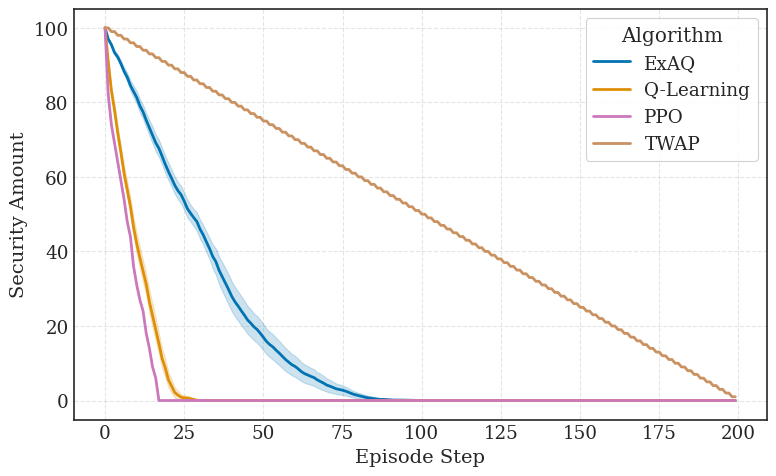

In [192]:
plot_strategies(strategies)

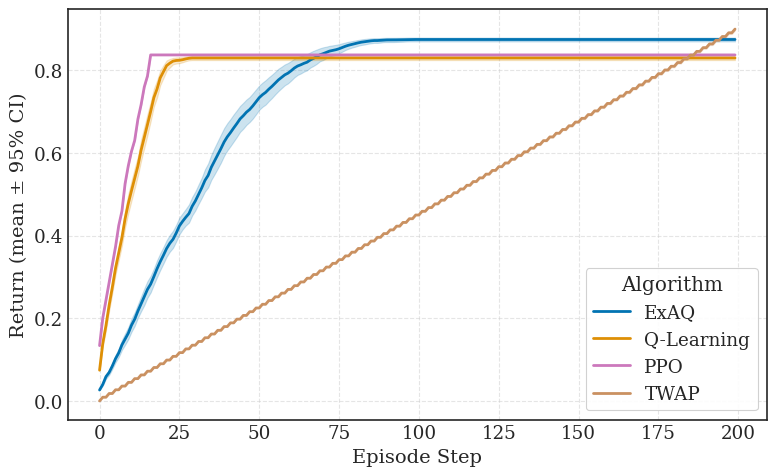

In [193]:
plot_performance(res_dict)

In [210]:
env = 'trading'
exp_name = 'fixedS0'

params = parameter_generator(f"pcmdp/{env}/world.yaml")

strategies = {}
res_dict = {}

# PPO no time
with open(f"logs/models/{env}/{exp_name}noTime/ppo/2025-12-24_10-45-06/1/best_model.pkl", "rb") as f:
    agent = pickle.load(f)
res_dict['ppo'], strategies['ppo'] = run_env(Q=None, env_id='trading-v0', params=params, seed=1234, n_episodes=50, agent=agent)

# PPO with time
with open(f"logs/models/{env}/{exp_name}withTime/ppo/2025-12-23_09-47-55/1/best_model.pkl", "rb") as f:
    agent = pickle.load(f)
res_dict['ppo_time'], strategies['ppo_time'] = run_env(Q=None, env_id='trading-v1', params=params, seed=1234, n_episodes=50, agent=agent)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 639.02it/s]


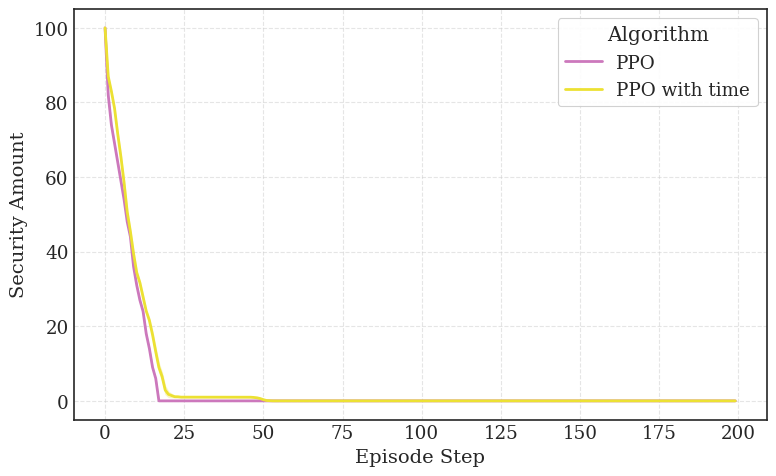

In [211]:
plot_strategies(strategies)

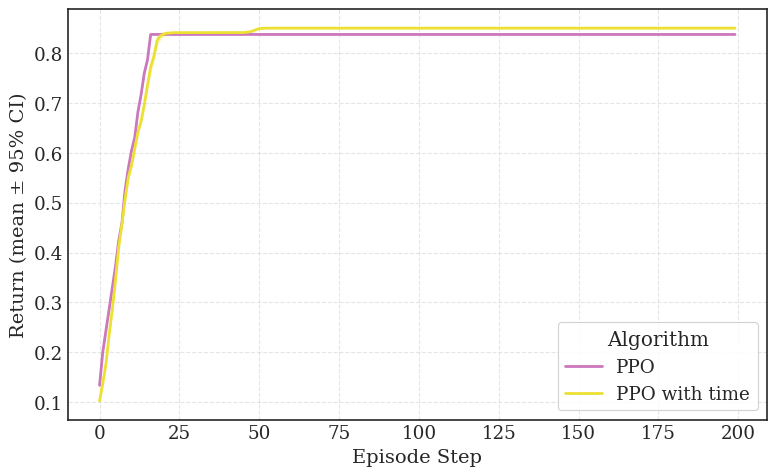

In [212]:
plot_performance(res_dict)